In [1]:
import os
import sys
import glob
import numpy as np

from parse import load_ps

import matplotlib.pyplot as plt

In [2]:
def split_num(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head, tail

In [3]:
def files_in_order(folderpath):
    npy_files = os.listdir(folderpath)

    no_extensions = [os.path.splitext(npy_file)[0] for npy_file in npy_files]

    splitted = [split_num(s) for s in no_extensions]

    splitted = np.array(splitted)

    indices = np.lexsort((splitted[:, 1].astype(int), splitted[:, 0]))

    npy_files = np.array(npy_files)
    return npy_files[indices]

In [4]:
files = files_in_order(os.path.join('poses_compressed', 'frontraise'))
print(files)

['frontraise_bad_1.npy' 'frontraise_bad_2.npy' 'frontraise_bad_3.npy'
 'frontraise_bad_4.npy' 'frontraise_bad_5.npy' 'frontraise_bad_6.npy'
 'frontraise_bad_7.npy' 'frontraise_bad_8.npy' 'frontraise_bad_9.npy'
 'frontraise_bad_10.npy' 'frontraise_bad_11.npy' 'frontraise_bad_12.npy'
 'frontraise_bad_13.npy' 'frontraise_good_1.npy' 'frontraise_good_2.npy'
 'frontraise_good_3.npy' 'frontraise_good_4.npy' 'frontraise_good_5.npy'
 'frontraise_good_6.npy' 'frontraise_good_7.npy' 'frontraise_good_8.npy'
 'frontraise_good_9.npy' 'frontraise_good_10.npy' 'frontraise_good_11.npy'
 'frontraise_good_12.npy' 'frontraise_good_13.npy'
 'frontraise_good_14.npy' 'frontraise_good_15.npy']


Starting: frontraise_bad_1.npy
Max angle:  76.44579393687194


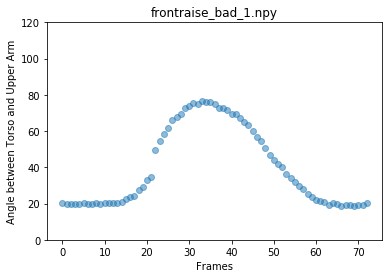

Starting: frontraise_bad_2.npy
Max angle:  76.53542334932135


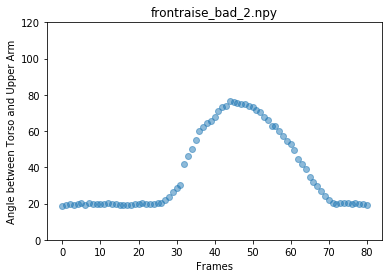

Starting: frontraise_bad_3.npy
Max angle:  83.44028662338161


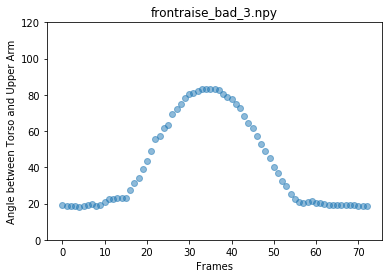

Starting: frontraise_bad_4.npy
Max angle:  91.45787597595873


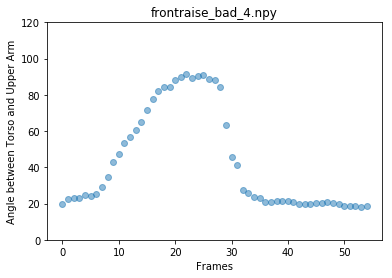

Starting: frontraise_bad_5.npy
Max angle:  73.68385164131362


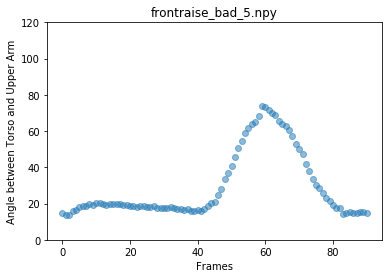

Starting: frontraise_bad_6.npy
Max angle:  77.0184894992613


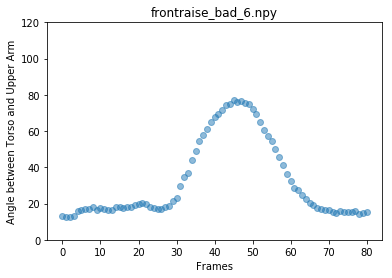

Starting: frontraise_bad_7.npy
Max angle:  93.2838786040392


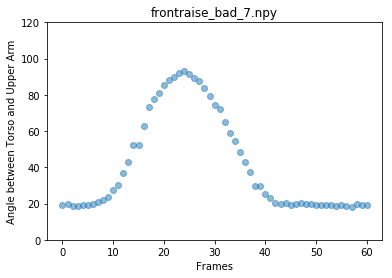

Starting: frontraise_bad_8.npy
Max angle:  61.81476558703318


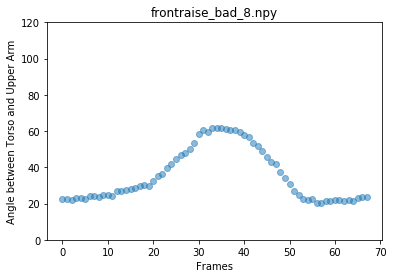

Starting: frontraise_bad_9.npy
Max angle:  70.16220719382201


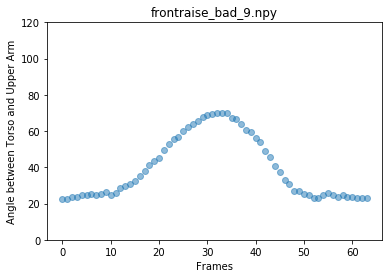

Starting: frontraise_bad_10.npy
Max angle:  67.74141626093673


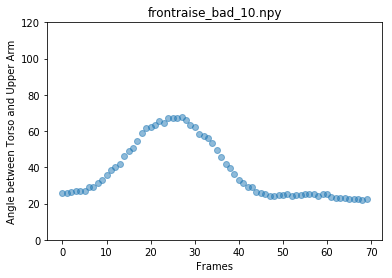

Starting: frontraise_bad_11.npy
Max angle:  65.60892049810339


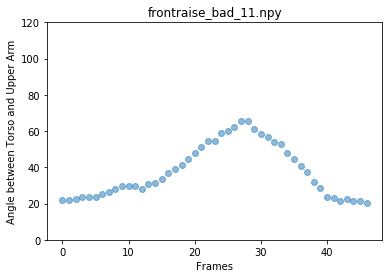

Starting: frontraise_bad_12.npy
Max angle:  73.49291738986014


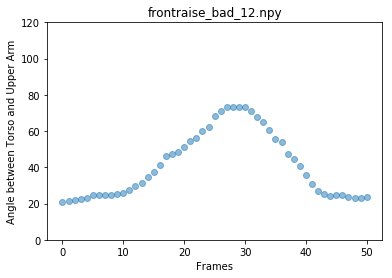

Starting: frontraise_bad_13.npy
Max angle:  65.20889427317152


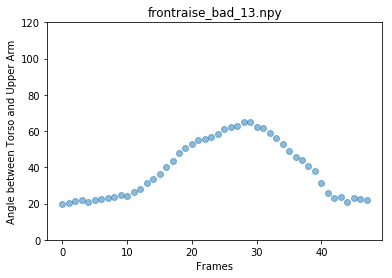

Starting: frontraise_good_1.npy
Max angle:  105.97905342601622


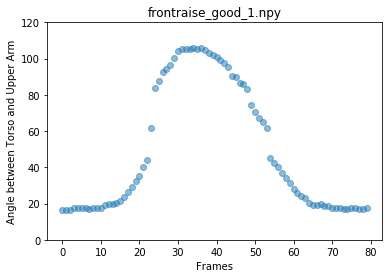

Starting: frontraise_good_2.npy
Max angle:  104.05891172589975


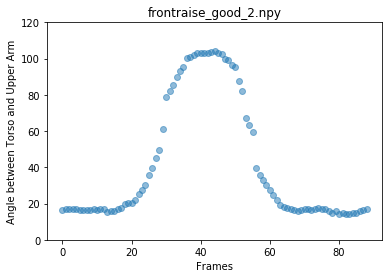

Starting: frontraise_good_3.npy
Max angle:  101.64971336209359


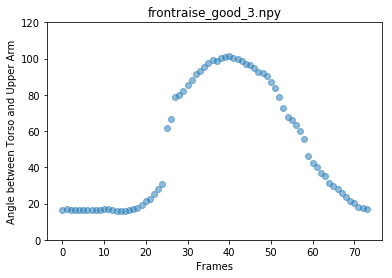

Starting: frontraise_good_4.npy
Max angle:  98.71037797092598


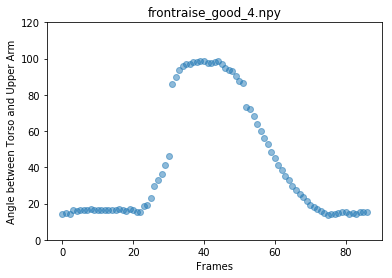

Starting: frontraise_good_5.npy
Max angle:  104.99856244779693


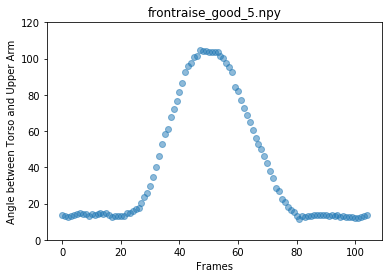

Starting: frontraise_good_6.npy
Max angle:  107.13825122517584


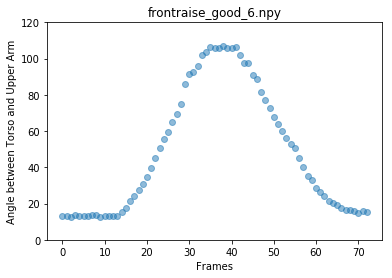

Starting: frontraise_good_7.npy
Max angle:  108.414909388629


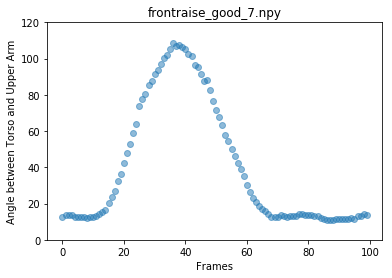

Starting: frontraise_good_8.npy
Max angle:  108.5533791991937


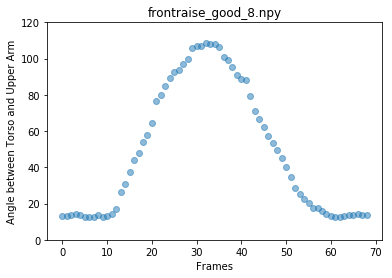

Starting: frontraise_good_9.npy
Max angle:  92.46571165603493


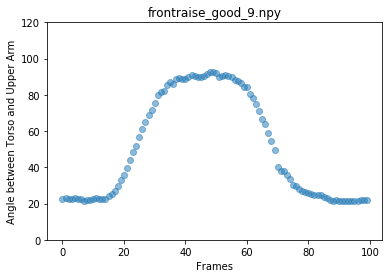

Starting: frontraise_good_10.npy
Max angle:  99.73228248176137


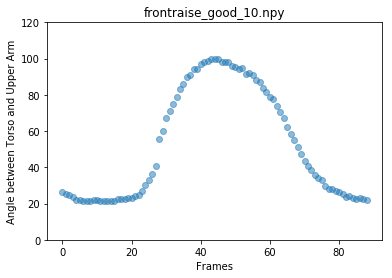

Starting: frontraise_good_11.npy
Max angle:  95.22134879096605


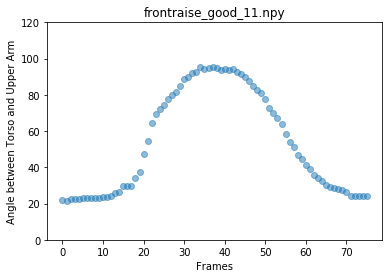

Starting: frontraise_good_12.npy
Max angle:  91.64297523968443


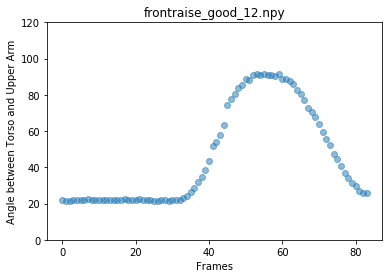

Starting: frontraise_good_13.npy
Max angle:  95.6042943399203


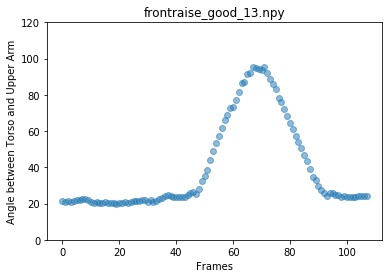

Starting: frontraise_good_14.npy
Max angle:  100.78599389212845


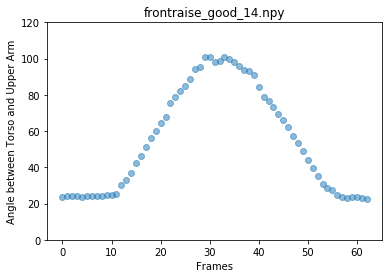

Starting: frontraise_good_15.npy
Max angle:  100.556373519022


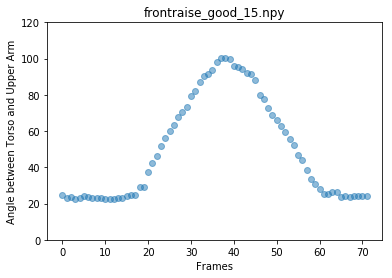

In [8]:
for filename in files:
    print("="*30)
    print("Starting:", filename)
    ps = load_ps("poses_compressed/frontraise/" + filename)
    poses = ps.poses
    
    right_present = [1 for pose in poses 
            if pose.rshoulder.exists and pose.relbow.exists and pose.rwrist.exists]
    left_present = [1 for pose in poses
            if pose.lshoulder.exists and pose.lelbow.exists and pose.lwrist.exists]
    right_count = sum(right_present)
    left_count = sum(left_present)
    side = 'right' if right_count > left_count else 'left'

    # print('Exercise arm detected as: {}.'.format(side))
    
    if side == 'right':
        joints = [(pose.rshoulder, pose.relbow, pose.rwrist, pose.rhip, pose.neck) for pose in poses]
    else:
        joints = [(pose.lshoulder, pose.lelbow, pose.lwrist, pose.lhip, pose.neck) for pose in poses]

    # filter out data points where a part does not exist
    joints = [joint for joint in joints if all(part.exists for part in joint)]
    joints = np.array(joints)
    
    # Neck to hip
    back_vec = np.array([(joint[4].x - joint[3].x, joint[4].y - joint[3].y) for joint in joints])
    # back_vec = np.array([(joint[3].x, joint[3].y) for joint in joints])
    # Check range of motion of the back
    # Straining back
    back_vec_range = np.max(back_vec, axis=0) - np.min(back_vec, axis=0)
    # print("Range of motion for back: %s" % back_vec_range)
    
    # threshold the x difference at 0.3: less is good, more is too much straining and movement of the back.
    
    # Shoulder to hip    
    torso_vecs = np.array([(joint[0].x - joint[3].x, joint[0].y - joint[3].y) for joint in joints])
    # Arm
    arm_vecs = np.array([(joint[0].x - joint[2].x, joint[0].y - joint[2].y) for joint in joints])
    
    # normalize vectors
    torso_vecs = torso_vecs / np.expand_dims(np.linalg.norm(torso_vecs, axis=1), axis=1)
    arm_vecs = arm_vecs / np.expand_dims(np.linalg.norm(arm_vecs, axis=1), axis=1)
    
    # Check if raised all the way up
    angles = np.degrees(np.arccos(np.clip(np.sum(np.multiply(torso_vecs, arm_vecs), axis=1), -1.0, 1.0)))
    print("Max angle: ", np.max(angles))
    
    plt.scatter(np.arange(angles.shape[0]), angles, alpha=0.5)
    plt.title(filename)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Torso and Upper Arm')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,120) 
    plt.show()
    
